# Outlier analysis

The purpose of this notebook is to analyze the dataset of Yeast, to find potential outliers.

## Imports

In [113]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
)
from subpred.util import get_clusters, perform_pca, get_protein_feature_stats
import numpy as np
from subpred.eval import full_test


## Creating the dataset

In [6]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    verbose = True,
    tax_ids_filter = [559292],
    output_log = "../logs/yeast_amino_sugar_dataset.log",
)

In [7]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,0.0,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
Q08986,Amino-acid transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,SAM3 YPL274W,S-adenosylmethionine permease SAM3 (S-adenosyl...,2.A.3.10.15,2.A,559292,MDILKRGNESDKFTKIETESTTIPNDSDRSGSLIRRMKDSFKQSNL...
P38967,Amino-acid transport,Membrane;Transmembrane,Transport,TAT2 LTG3 SAB2 SCM2 TAP2 YOL020W,Tryptophan permease (Tryptophan amino acid tra...,2.A.3.10.8,2.A,559292,MTEDFISSVKRSNEELKERKSNFGFVEYKSKQLTSSSSHNSNSSHH...
P39003,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,0.0,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P38085,Amino-acid transport,Membrane;Transmembrane,Transport,TAT1 TAP1 VAP1 YBR069C YBR0710,Valine/tyrosine/tryptophan amino-acid permease...,2.A.3.10.9,2.A,559292,MDDSVSFIAKEASPAQYSHSLHERTHSEKQKRDFTITEKQDEVSGQ...


In [8]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)

### Stats

The dataset is imbalanced, and there are no multi-substrate transporters in the dataset. In general, the number of samples should be barely enough for a good model. 

In [9]:
df.keywords_transport.value_counts()

Amino-acid transport    36
Sugar transport         28
Name: keywords_transport, dtype: int64

In contrast to the other organisms, the class separation actually looks okay in the PCA. We should look at the clusters later.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

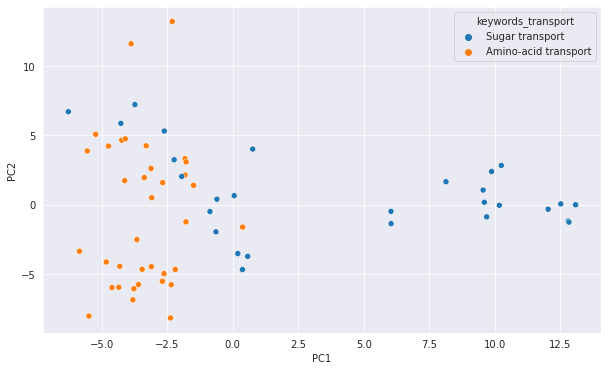

In [10]:
pca_plot_2d(df_paac, df.keywords_transport)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

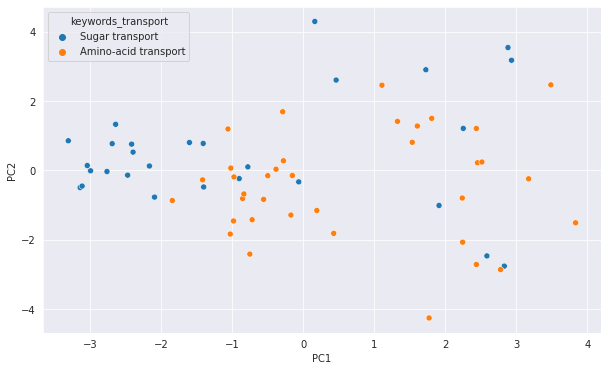

In [11]:
pca_plot_2d(df_aac, df.keywords_transport)

#### Locations

Few proteins are annotated with a specific membrane. 

In [12]:
df.keywords_location.value_counts()

Membrane;Transmembrane                                        44
Cell membrane;Membrane;Transmembrane                           9
Endoplasmic reticulum;Membrane;Transmembrane                   6
Membrane;Mitochondrion;Transmembrane                           3
Cell membrane;Endoplasmic reticulum;Membrane;Transmembrane     2
Name: keywords_location, dtype: int64

From a sample of 5 proteins without specific membrane, four are in cell membrane and one in ER membrane according to GO annotations. The location data is simply missing in the keywords database.

In [13]:
df[df.keywords_location == "Membrane;Transmembrane"].sample(5, random_state=0)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P54854,Sugar transport,Membrane;Transmembrane,Transport,HXT15 YDL245C,Hexose transporter HXT15,2.A.1.1.107,2.A,559292,MASEQSSPEINADNLNSSAADVHVQPPGEKEWSDGFYDKEVINGNT...
P38734,Amino-acid transport,Membrane;Transmembrane,Transport,MUP3 YHL036W,Low-affinity methionine permease,2.A.3.8.16,2.A,559292,MEPLLFNSGKANPSQDVFIDVEVGDITTKYGSTNTGSFSSMDTVEA...
P06775,Amino-acid transport,Membrane;Transmembrane,Transport,HIP1 YGR191W G7572,Histidine permease,2.A.3.10.1,2.A,559292,MPRNPLKKEYWADVVDGFKPATSPAFENEKESTTFVTELTSKTDSA...
P23585,Sugar transport,Membrane;Transmembrane,Transport,HXT2 YMR011W YM8270.15,High-affinity glucose transporter HXT2,2.A.1.1.111,2.A,559292,MSEFATSRVESGSQQTSIHSTPIVQKLETDESPIQTKSEYTNAELP...
P39932,Sugar transport,Membrane;Transmembrane,Transport,STL1 YDR536W D9719.39,Sugar transporter STL1,2.A.1.1.38,2.A,559292,MKDLKLSNFKGKFISRTSHWGLTGKKLRYFITIASMTGFSLFGYDQ...


In the PCA plot, some of the sugar ER and MT transporters mix in with the amino transporters, while some of the Cell membrane transporters stay separate.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

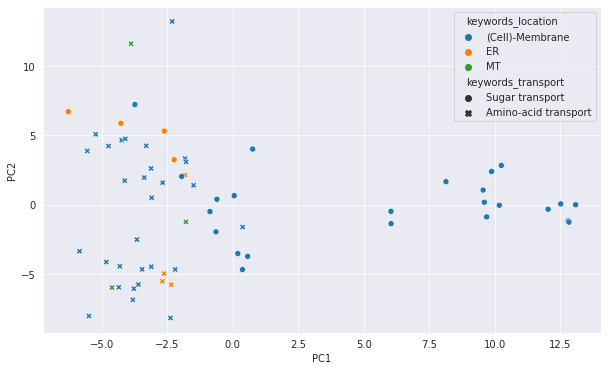

In [14]:
pca_plot_2d(
    df_paac,
    df.keywords_location.transform(
        lambda x: "MT" if "Mito" in x else ("ER" if "Endo" in x else "(Cell)-Membrane")
    ),
    labels2=df.keywords_transport,
)

MT transporters can be barrel proteins, is that the case here?

In [15]:
df[df.keywords_location.str.contains("Mito")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q12029,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,FSF1 YOR271C,Sideroflexin FSF1 (Fungal sideroflexin-1),2.A.54.1.4,2.A,559292,MASSVPGPIDLPESRYDLSTYWGRIRHCAEISDPTMLLTTEKDLAH...
P38279,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,RTC2 YPQ3 YBR147W YBR1124,Probable vacuolar amino acid transporter YPQ3 ...,2.A.43.2.7,2.A,559292,MKLIPIILNAKNLSGMAGSISICCWIVVFVPQIYENFRRQSAEGLS...
P48813,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,GNP1 YDR508C D9719.14,High-affinity glutamine permease,2.A.3.10.5,2.A,559292,MTLGNRRHGRNNEGSSNMNMNRNDLDDVSHYEMKEIQPKEKQIGSI...


No, they all look like alpha bundle transporters according to alphafold

What are the proteins with high PC1?

In [16]:
pca_paac = perform_pca(df_paac, df.keywords_transport)

df.loc[pca_paac.query("PC1 > 5").index].gene_names.apply(lambda x: x.split()[0])

Uniprot
P39003     HXT6
P23585     HXT2
P39004     HXT7
P32465     HXT1
P40886     HXT8
P13181     GAL2
P32467     HXT4
P40885     HXT9
P54854    HXT15
P38695     HXT5
P43581    HXT10
P32466     HXT3
P54862    HXT11
P39924    HXT13
Name: gene_names, dtype: object

They belong to the HXT family. There is one non-HXT protein in the cluster, and one HXT proteins mixes with the remaining data:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

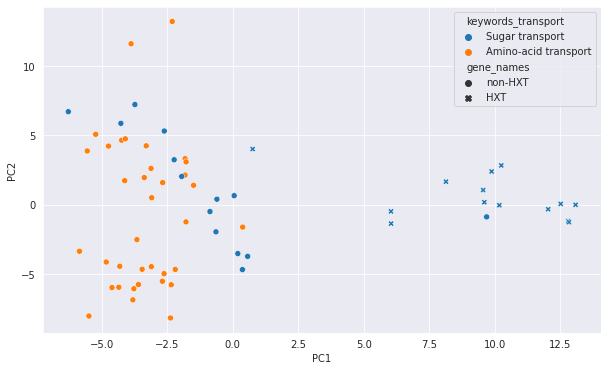

In [17]:
pca_plot_2d(
    df_paac,
    df.keywords_transport,
    df.gene_names.apply(lambda x: "HXT" if "HXT" in x else "non-HXT"),
)

The remaining sugar transporters seem to be mixed:

In [18]:
df.loc[
    pca_paac[
        (pca_paac.PC1 < 5) & (pca_paac.keywords_transport.str.startswith("Sugar"))
    ].index
].gene_names.apply(lambda x: x.split()[0])


Uniprot
P0CD99       MPH2
P38206       RFT1
Q12300       RGT2
Q03697       YMD8
P10870       SNF3
P39932       STL1
P42833      HXT14
P38156      MAL31
P0CE00       MPH3
P40107       VRG4
P53048      MAL11
Q12520       HUT1
P40004       YEA4
Q04162    YDR387C
Name: gene_names, dtype: object

There is nothing notable about the two transporters with high PC2

In [19]:
df.loc[
    pca_paac[
        (pca_paac.PC2 >10) & (pca_paac.keywords_transport.str.startswith("Amino"))
    ].index
].gene_names.apply(lambda x: x.split()[0])


Uniprot
Q12010    YPQ1
P38279    RTC2
Name: gene_names, dtype: object

#### TCDB

This dataset is almost completely annotated with TCDB identifiers. Almost all of them are passive transporters in class 2.A. Nine transporter are not annotated.

In [20]:
df.tcdb_class.value_counts()

2.A    55
0.0     9
Name: tcdb_class, dtype: int64

What are the proteins without TCDB entry?

In [21]:
df[df.tcdb_class.str.startswith("0")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,0.0,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P39003,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,0.0,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P40886,Sugar transport,Membrane;Transmembrane,Transport,HXT8 YJL214W HRA569 J0232,Hexose transporter HXT8,NaN,0.0,559292,MTDRKTNLPEEPIFEEAEDDGCPSIENSSHLSVPTVEENKDFSEYN...
P38156,Sugar transport,Membrane;Transmembrane,Transport,MAL31 MAL3T YBR298C YBR2116,Maltose permease MAL31 (Maltose transport prot...,NaN,0.0,559292,MKGLSSLINRKKDRNDSHLDEIENGVNATEFNSIEMEEQGKKSDFD...
P40885,Sugar transport,Membrane;Transmembrane,Transport,HXT9 YJL219W HRC567 J0222,Hexose transporter HXT9,NaN,0.0,559292,MSGVNNTSANDLSTTESNSNSVANAPSVKTEHNDSKNSLNLDATEP...
P0CE00,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH3 YJR160C J2400,Alpha-glucosides permease MPH3 (Maltose transp...,NaN,0.0,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P38695,Sugar transport,Membrane;Transmembrane,Transport,HXT5 YHR096C,Probable glucose transporter HXT5,NaN,0.0,559292,MSELENAHQGPLEGSATVSTNSNSYNEKSGNSTAPGTAGYNDNLAQ...
P32466,Sugar transport,Membrane;Transmembrane,Transport,HXT3 YDR345C D9651.14,Low-affinity glucose transporter HXT3,NaN,0.0,559292,MNSTPDLISPQKSSENSNADLPSNSSQVMNMPEEKGVQDDFQAEAD...
P25594,Amino-acid transport,Membrane;Transmembrane,Transport,VBA3 YCL069W YCL69W,Vacuolar basic amino acid transporter 3,NaN,0.0,559292,MNMLIVGRVVASVGGSGLQTLCFVIGCTMVGERSRPLVISILSCAF...


Four belong to the HXT family. One is called a "probable transporter", and its function is manually annotated based on similar protein in an ancestor. Nothing important

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

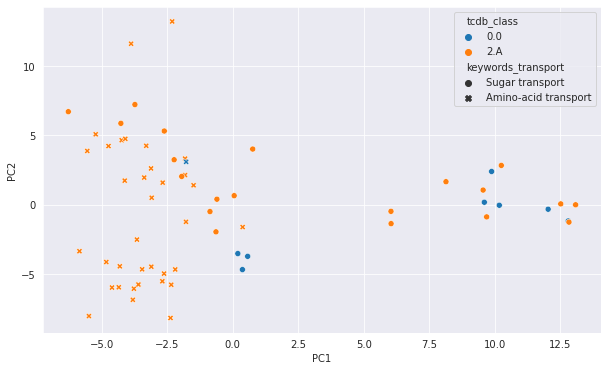

In [22]:
pca_plot_2d(df_paac, df.tcdb_class, df.keywords_transport)

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

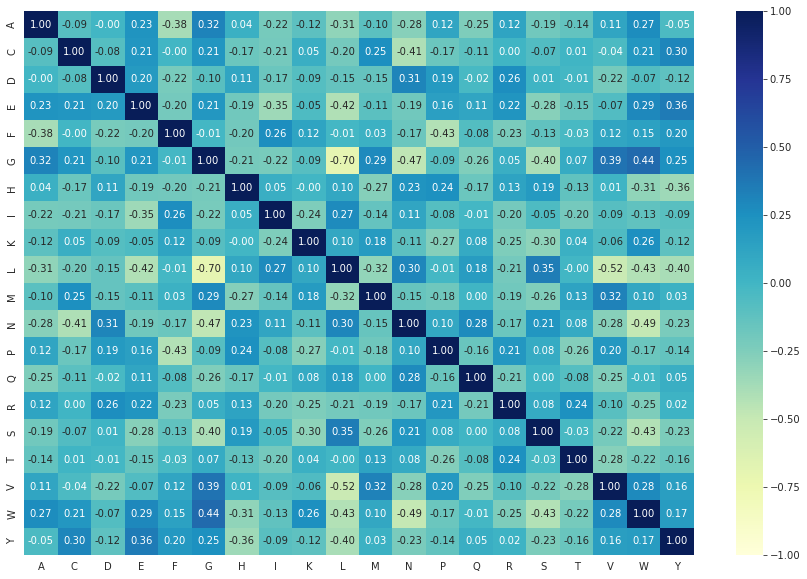

In [23]:
corr_heatmap(df_aac)

<AxesSubplot:>

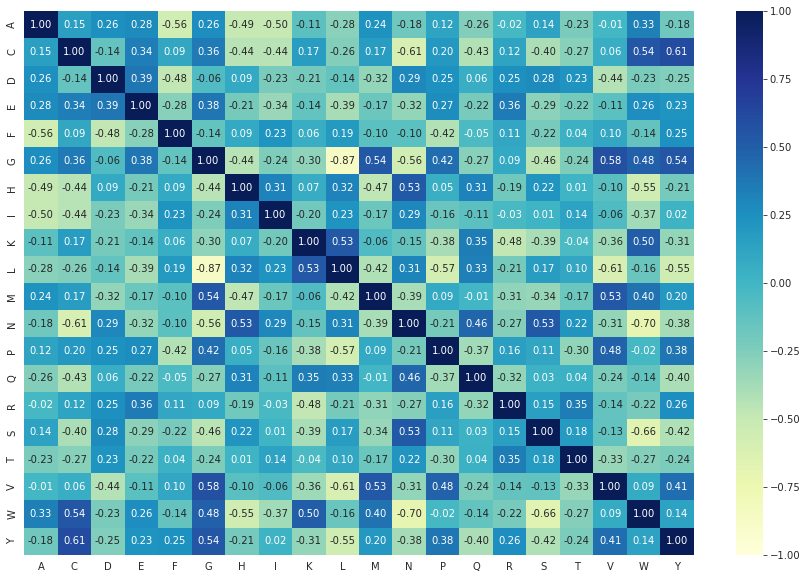

In [24]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

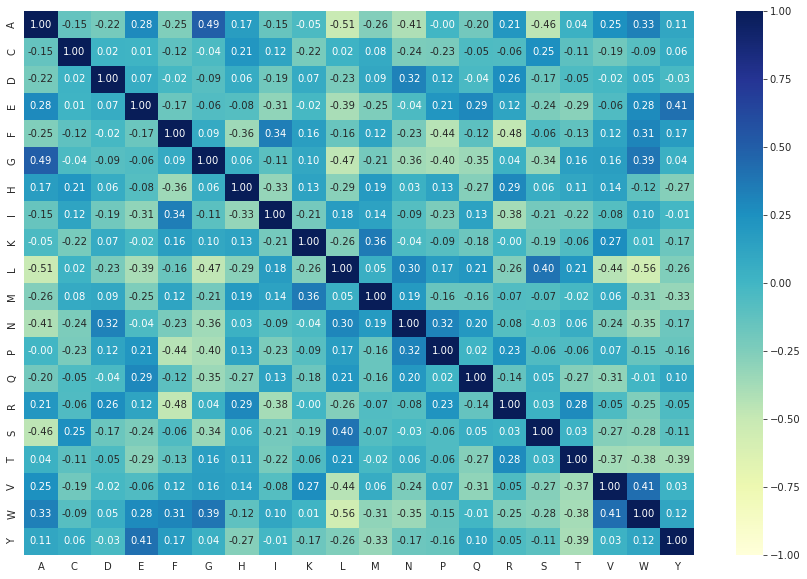

In [25]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

### Distribution

According to shapiro-wilk, the features mostly follow a normal dist.

<AxesSubplot:>

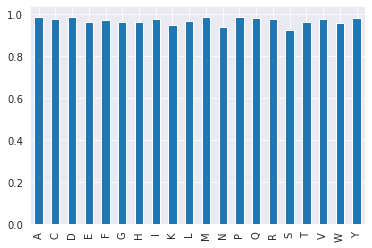

In [26]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

#### Deviations

There is some slight deviation for Serine and Asparagine. They could theoretically play a role in selectivity in some proteins.

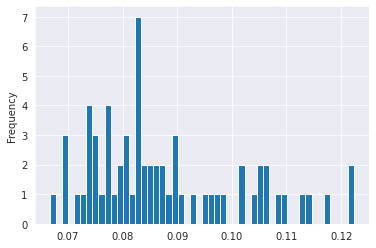

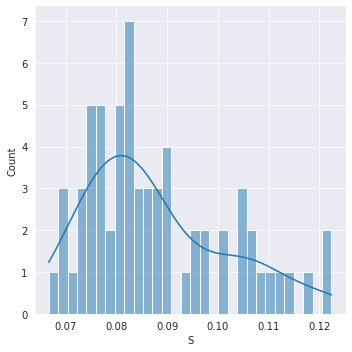

In [27]:
df_aac.S.plot.hist(bins=50)

import seaborn as sns

sns.displot(df_aac.S, kde=True, bins=30)

In [54]:
df.loc[df_aac.query("S > 0.11").index].join(df_aac.S, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,S
Uniprot,,,,,,,,,
Q04602,Amino-acid transport,Membrane;Transmembrane,Transport,VBA4 YDR119W,Vacuolar basic amino acid transporter 4,2.A.1.48.5,2.A,559292,0.122396
P10870,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SNF3 YDL194W D1234,Low glucose sensor SNF3 (High-affinity glucose...,2.A.1.1.17,2.A,559292,0.114253
P36062,Amino-acid transport,Membrane;Transmembrane,Transport,AVT3 YKL146W YKL600,Vacuolar amino acid transporter 3,2.A.18.7.1,2.A,559292,0.112717
P25568,Amino-acid transport,Membrane;Transmembrane,Transport,ATG22 AUT4 YCL038C YCL38C,Autophagy-related protein 22,2.A.1.24.1;9.A.15.1.1,2.A,559292,0.117424
P38358,Amino-acid transport,Membrane;Transmembrane,Transport,VBA2 YBR293W YBR2109,Vacuolar basic amino acid transporter 2,2.A.1.48.2,2.A,559292,0.122363


There are three Vacuolar amino acid transporters. Also, there is a protein called a "low glucose sensor", which is similar to other glucose transporter but does not actually transport. It sends an intracellular signal that activates HXT2. Are there more sensors?

In [ ]:
df[df.protein_names.str.match(".*[Ss]ensor.*")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q12300,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,RGT2 YDL138W D2160,High glucose sensor RGT2 (Low-affinity glucose...,2.A.1.1.19,2.A,559292,MNDSQNCLRQREENSHLNPGNDFGHHQGAECTINHNNMPHRNAYTE...
P10870,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SNF3 YDL194W D1234,Low glucose sensor SNF3 (High-affinity glucose...,2.A.1.1.17,2.A,559292,MDPNSNSSSETLRQEKQGFLDKALQRVKGIALRRNNSNKDHTTDDT...


There is also a high glucose sensor. It is also similar to glucose transporters, and also does not transport glucose itself. Depending on how different they are to actual transporters, it might be worth keeping them in the dataset, or removing them. In terms of the PAAC PCA, they fit in with the non-HXT sugar transporters

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

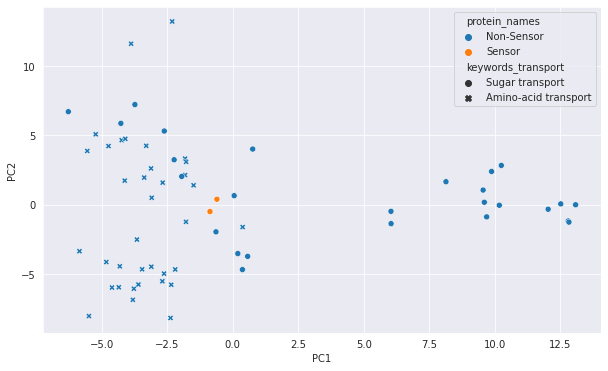

In [31]:
pca_plot_2d(df_paac, df.protein_names.transform(lambda x: "Sensor" if "sensor" in x else "Non-Sensor"), df.keywords_transport)

Are there more probable transporters?

In [49]:
df[df.protein_names.str.match("(?i).*(probable|predicted).*")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q12010,Amino-acid transport,Membrane;Transmembrane,Transport,YPQ1 YOL092W O0929,Probable vacuolar amino acid transporter YPQ1 ...,2.A.43.2.3,2.A,559292,MQLVPLELNRSTLSGISGSISISCWIIVFVPQIYENFYRKSSDGLS...
P38695,Sugar transport,Membrane;Transmembrane,Transport,HXT5 YHR096C,Probable glucose transporter HXT5,NaN,0.0,559292,MSELENAHQGPLEGSATVSTNSNSYNEKSGNSTAPGTAGYNDNLAQ...
P38279,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,RTC2 YPQ3 YBR147W YBR1124,Probable vacuolar amino acid transporter YPQ3 ...,2.A.43.2.7,2.A,559292,MKLIPIILNAKNLSGMAGSISICCWIVVFVPQIYENFRRQSAEGLS...
Q06328,Amino-acid transport,Membrane;Transmembrane,Transport,YPQ2 YDR352W,Probable vacuolar amino acid transporter YPQ2 ...,2.A.43.2.8,2.A,559292,MSCSNGIWPTVSNLCGSLSFFTSVISLFPQIIETYRDKSVDGLSPY...
Q04162,Sugar transport,Membrane;Transmembrane,Transport,YDR387C,Probable metabolite transport protein YDR387C,2.A.1.1.101,2.A,559292,MSTDESEDVYSDLYSIISQVTSNTANDIEQLPYALTFKTSLIFVGA...


Yes, although the word "probable" seems to refer to the cellular location, which is the vacuolar membrane. How many vacuolar proteins are there, and how do they fit into the dataset?

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

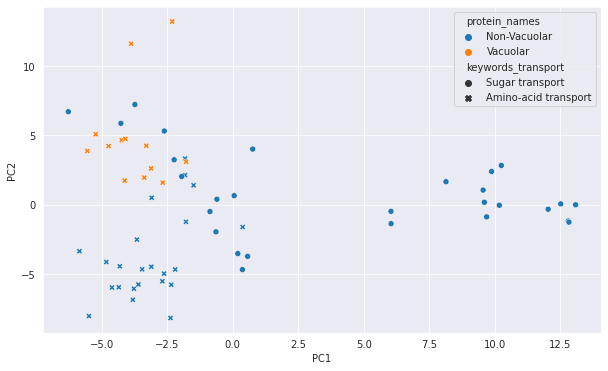

In [52]:
pca_plot_2d(
    df_paac,
    df.protein_names.transform(
        lambda x: "Vacuolar" if "vacuol" in x.lower() else "Non-Vacuolar"
    ),
    df.keywords_transport,
)

#### Distribution of Asparagine

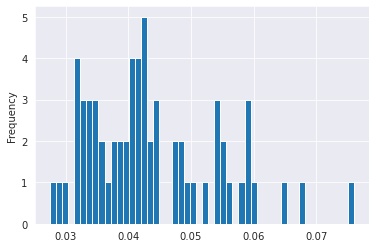

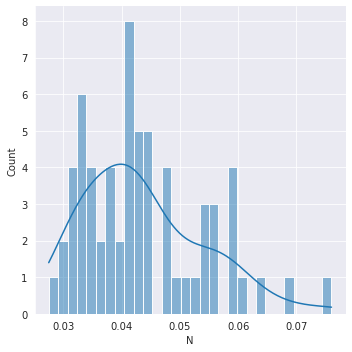

In [ ]:
df_aac.N.plot.hist(bins=50)

sns.displot(df_aac, x="N", kde=True, bins=30)

In [53]:
df.loc[df_aac[df_aac.N > 0.065].index].join(df_aac.N, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,N
Uniprot,,,,,,,,,
Q12300,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,RGT2 YDL138W D2160,High glucose sensor RGT2 (Low-affinity glucose...,2.A.1.1.19,2.A,559292,0.076016
Q12010,Amino-acid transport,Membrane;Transmembrane,Transport,YPQ1 YOL092W O0929,Probable vacuolar amino acid transporter YPQ1 ...,2.A.43.2.3,2.A,559292,0.068182


Here we find the high-glucose sensor, while the search for high-serine transporters led to us discovering the low-glucose sensor. Maybe these amino acids are related to the deactivated status?

## PSSM analysis

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

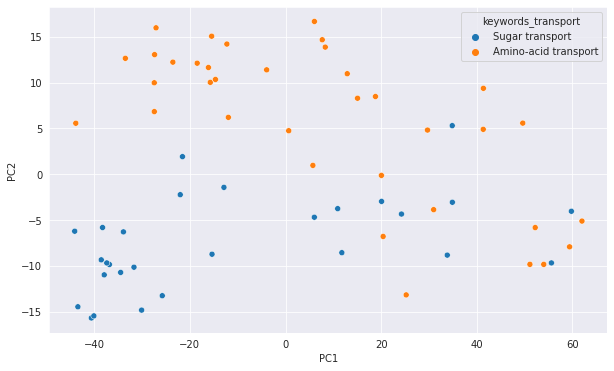

In [106]:
from subpred.pssm import calculate_pssms_notebook

df_pssm = calculate_pssms_notebook(df.sequence)

pca_plot_2d(df_pssm, df.keywords_transport)

#### Eval with  sensors

In [117]:

scores, params = full_test(df_paac, df.keywords_transport)
scores_gr = scores.groupby(["label", "dataset"], as_index=False)
print("mean PAAC")
display(scores_gr.mean().pivot("label", "dataset", "F1 score"))
print("sdev PAAX")
display(scores_gr.std().pivot("label", "dataset", "F1 score"))

scores, params = full_test(df_pssm, df.keywords_transport)
scores_gr = scores.groupby(["label", "dataset"], as_index=False)
print("mean PSSM")
display(scores_gr.mean().pivot("label", "dataset", "F1 score"))
print("sdev PSSM")
display(scores_gr.std().pivot("label", "dataset", "F1 score"))

mean PAAC


dataset,test,train
label,,
Amino-acid transport,0.9188,0.8905
Sugar transport,0.8679,0.8006


sdev PAAX


dataset,test,train
label,,
Amino-acid transport,0.061543,0.028695
Sugar transport,0.119573,0.072785


mean PSSM


dataset,test,train
label,,
Amino-acid transport,0.9170,0.9146
Sugar transport,0.8921,0.8663


sdev PSSM


dataset,test,train
label,,
Amino-acid transport,0.054477,0.04833
Sugar transport,0.076336,0.06966


#### Eval without sensors

In [116]:
mask_sensor = ~df.protein_names.str.lower().transform(lambda x: "sensor" in x)
print(mask_sensor.value_counts())

scores, params = full_test(df_paac.loc[mask_sensor], df.keywords_transport.loc[mask_sensor])
scores_gr = scores.groupby(["label", "dataset"], as_index=False)
print("mean PAAC")
display(scores_gr.mean().pivot("label", "dataset", "F1 score"))
print("sdev PAAC")
display(scores_gr.std().pivot("label", "dataset", "F1 score"))
scores, params = full_test(df_pssm.loc[mask_sensor], df.keywords_transport.loc[mask_sensor])
scores_gr = scores.groupby(["label", "dataset"], as_index=False)
print("mean PSSM")
display(scores_gr.mean().pivot("label", "dataset", "F1 score"))
print("sdev PSSM")
display(scores_gr.std().pivot("label", "dataset", "F1 score"))

True     62
False     2
Name: protein_names, dtype: int64
mean PAAC


dataset,test,train
label,,
Amino-acid transport,0.9078,0.8894
Sugar transport,0.7670,0.7980


sdev PAAC


dataset,test,train
label,,
Amino-acid transport,0.062044,0.020876
Sugar transport,0.209281,0.051312


mean PSSM


dataset,test,train
label,,
Amino-acid transport,0.9017,0.9086
Sugar transport,0.7942,0.8380


sdev PSSM


dataset,test,train
label,,
Amino-acid transport,0.052130,0.021030
Sugar transport,0.139203,0.053214


Conclusion: Removing the sensor proteins lowers the number of sugar transporters in the dataset, and leads to worse classification results.

## Summary

In terms of sequence and PSSM, we did not find any outliers. Two proteins are sensors, they are very similar to transporters but do not transport themselves. However, removing them from the dataset led to slightly worse results, presumably because of the low number of samples.